In [1]:
import torch
from models import load_model
from config import MODELS_PATH, CACHE_PATH, TEST_DATA

from utils import set_up_logging
from training import HistogramDataset


set_up_logging()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


image = 127

model, hyperparameters = load_model(MODELS_PATH / "run_13", device)

dataset = HistogramDataset(
    TEST_DATA,
    edit_count=hyperparameters["edit_count"],
    bin_count=hyperparameters["bin_count"],
    delete_corrupt_images=False,
    cache_path=CACHE_PATH,
    target_size=(640, 640),
)

2024-06-28 07:27:25,239 - INFO - Loading model from /home/andras/projects/bipolaroid/saved_models/run_13
2024-06-28 07:27:25,240 - INFO - Hyperparameters: {'batch_size': 64, 'edit_count': 12, 'bin_count': 16, 'learning_rate': 0.00346006104230179, 'scheduler_gamma': 0.8696229263858167, 'num_epochs': 12, 'elu_alpha': 1.3186797055872976, 'leaky_relu_slope': 0.028723863794983127, 'dropout_prob': 0.0483439200772893, 'features': [16, 16, 16], 'use_residual': False, 'kernel_size': 3, 'model_type': 'HistogramNet', 'use_instance_norm': False, 'use_elu': True, 'leaky_relu_alpha': 0.03164975177595501}
2024-06-28 07:27:26,746 - INFO - Parameter count: 28641
2024-06-28 07:27:26,751 - INFO - Loaded 2498 original images


In [2]:
from visualisation import plot_histograms_in_3d
from utils import compute_histogram
from PIL import Image

original_image = dataset.get_original_image(image)

original_histogram = (
    torch.tensor(
        compute_histogram(
            original_image, bins=hyperparameters["bin_count"], normalize=True
        ),
        dtype=torch.float,
    )
    .unsqueeze(0)
    .unsqueeze(0)
).to(device)

edited_image = dataset.get_edited_image(image, 5)
# edited_image = Image.open("../data/IMG_3566.JPG")
# edited_image.thumbnail((640, 640))
edited_histogram = (
    torch.tensor(
        compute_histogram(
            edited_image, bins=hyperparameters["bin_count"], normalize=True
        )
    )
    .unsqueeze(0)
    .unsqueeze(0)
).to(device)


predicted_histogram = model(edited_histogram)

# plot_histograms_in_3d(
#     {
#         "original": original_histogram.cpu().numpy().squeeze(),
#         "edited": edited_histogram.cpu().numpy().squeeze(),
#         "predicted": predicted_histogram.cpu().detach().numpy().squeeze(),
#     }
# )

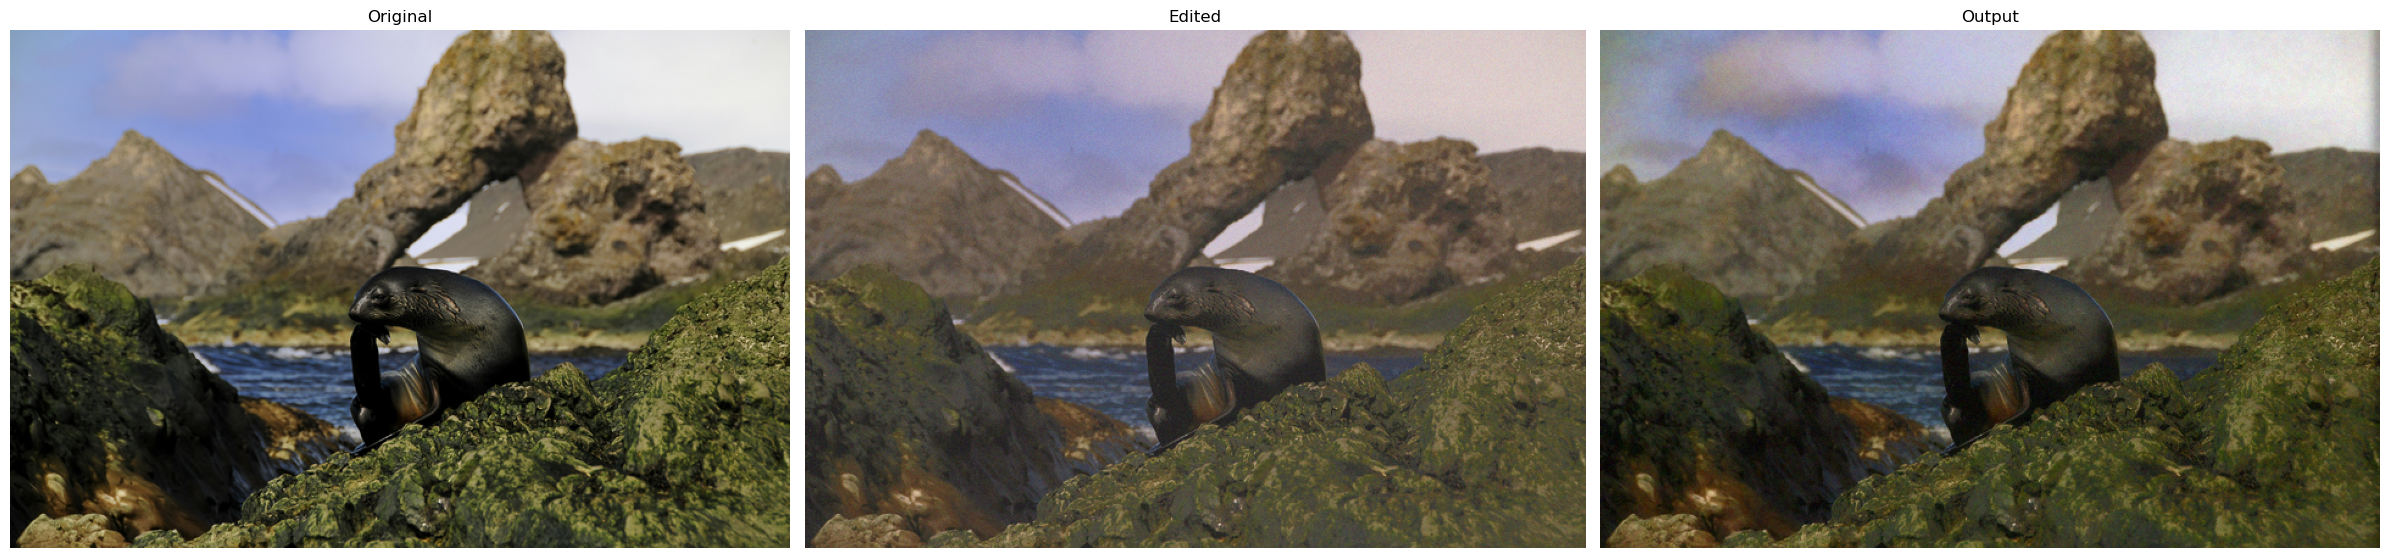

In [3]:
from visualisation import display_images
from histogram_transfer import apply_histogram
from PIL import Image

output = apply_histogram(
    edited_image, predicted_histogram, hyperparameters["bin_count"]
)

display_images(
    {
        "Original": original_image,
        "Edited": edited_image,
        "Output": Image.fromarray(output),
    }
)
plot_histograms_in_3d(
    {
        "original": compute_histogram(
            original_image, bins=hyperparameters["bin_count"], normalize=True
        ),
        "edited": compute_histogram(
            edited_image, bins=hyperparameters["bin_count"], normalize=True
        ),
        "predicted": compute_histogram(
            Image.fromarray(output), bins=hyperparameters["bin_count"], normalize=True
        ),
    },
)